# For an analysis competition...
What to predict?
- age ... too few nans (prediction may be meaningless...)
- cancellation of premium membership

# Libraries

In [1]:
# basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import time
import datetime
import os
import sys
import pickle
from tqdm import tqdm_notebook as tqdm

# keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, LambdaCallback
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.layers import Input, Layer, Dense, Concatenate, Reshape, Dropout, merge, Add, BatchNormalization, GaussianNoise
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.layers import Layer
from keras.callbacks import *
import tensorflow as tf
import math

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
import plotly.figure_factory as ff
import plotly.express as px
import missingno as msno

sns.set_context("talk")
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
style.use('fivethirtyeight')

# custom EDA functions
mypath = os.getcwd()
sys.path.append(mypath + '/code/') 
from utils import reduce_mem_usage, plot_target
from categorical_encoder import label_encoding
from feature_converter import categorize_features
from adversarial_validaton import AdversarialValidation
from catplot import CategoricalVisualizer
from denseplot import DenseVisualizer
from nn_utils import Mish, LayerNormalization, CyclicLR
from permutation_importance import PermulationImportance

# custom modeling functions
sys.path.append(mypath + '/models/') 
from base_models import BaseModel
from lgb_models import LgbModel
from catb_models import CatbModel

# stats
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error, log_loss
from sklearn.model_selection import train_test_split
import scipy as sp
from functools import partial
from collections import Counter

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

print("libraries imported")

Using TensorFlow backend.


libraries imported


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



# Load data

In [2]:
!ls

EDA.ipynb            EDA_titanic.ipynb    models
EDA_houseprice.ipynb code                 nn_laputa.ipynb
EDA_laputa.ipynb     inputs


In [3]:
# check path
datapath = "inputs/"
datapath = "/Volumes/sec/anemos-poc-large-sec/users/kakawagu/data/laputa_comp"
files = os.listdir(datapath)
print(files)

['laputa_age.csv', '.DS_Store', 'figs', 'laputa.csv', 'laputa_noage.csv']


In [4]:
# import data
time0 = time.time()

train = pd.read_csv(datapath + '/laputa_age.csv', index_col=0)
test = pd.read_csv(datapath + '/laputa_noage.csv', index_col=0)

time1 = time.time()
print(time1 - time0, " seconds to load data")

4.436133146286011  seconds to load data


In [5]:
# check train
print(train.shape)
train.head()

(10000, 815)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,2_user_profile_master_commerce_registration_month,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,0012356A351358D871,1,NaN,20190428,20190501.0,20191201,49,8,31,8,...,NaN,0.067452,NaN,NaN,NaN,NaN,0.05795,NaN,NaN,NaN
1,00148ED6D273F9B2DD,1,NaN,20160925,20160929.0,20191127,45,39,166,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0003BCA15E2EFB1955,1,NaN,20160508,20160513.0,20191130,23,43,186,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000A7D82545E783A8E,1,NaN,20160612,20160615.0,20191201,42,42,181,42,...,NaN,0.035689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000A84CEFE8881F2AA,1,NaN,20191020,20191022.0,20191201,58,2,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# check test
print(test.shape)
test.head()

(10000, 815)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,2_user_profile_master_commerce_registration_month,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,0013CB9311A8ADDE2C,0,NaN,20170528,20170530.0,20191201,NaN,31,131,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039645C6FA1C0ABC,0,NaN,20190224,20190301.0,20191201,NaN,10,40,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00151F8DE7DFD5D93C,0,NaN,20190623,20190627.0,20191201,NaN,6,23,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000C53CB2E2051E6A2,0,NaN,20190616,20190620.0,20191201,NaN,6,24,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0012E6705A765C2DA2,0,NaN,20190922,20190923.0,20191201,NaN,3,10,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Target

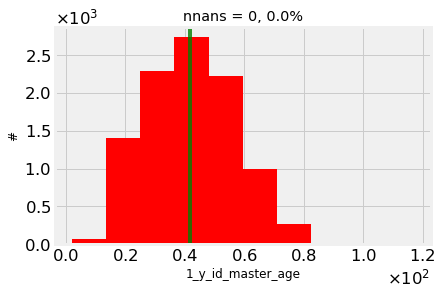

In [7]:
# hist
target = "1_y_id_master_age"
plot_target(train, target, objective="regression")

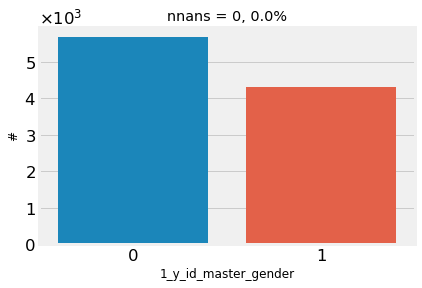

In [8]:
# hist
target = "1_y_id_master_gender"
plot_target(train, target, objective="classification")

In [9]:
# binarize gender
train["1_y_id_master_gender"] -= 1
train.loc[train["1_y_id_master_gender"] < 0, "1_y_id_master_gender"] = 0

# multi-task
target = ["1_y_id_master_age", "1_y_id_master_gender"]

# Dense features

In [10]:
dense_features = ['1_y_id_master_registration_date', '1_y_id_master_first_update', '1_y_id_master_last_update', '1_y_id_master_registration_month', '1_y_id_master_registration_week', '2_user_profile_master_commerce_registration_month', '2_user_profile_master_commerce_age', '2_user_profile_master_commerce_shopping_order_count', '2_user_profile_master_commerce_auction_won_count', '2_user_profile_master_commerce_auction_bid_aid_count', '2_user_profile_master_commerce_auction_submit_count', '2_user_profile_master_commerce_auction_sold_count', '2_user_profile_master_commerce_earned_point_count', '2_user_profile_master_commerce_monthly_fixed_point', '2_user_profile_master_commerce_used_point_count', '2_user_profile_master_commerce_used_point', '2_user_profile_master_commerce_invalid_ypoint', '3_points_monthly_summary_interim_point_y', '3_points_monthly_summary_fixed_point_y', '3_points_monthly_summary_fixed_point_t', '4_point_user_balance_master_interim_point_y', '4_point_user_balance_master_fixed_point_y', '4_point_user_balance_master_fixed_point_t', '8_app_user_monthly_stats_toppage_activate_day', '8_app_user_monthly_stats_weather_activate_day', '8_app_user_monthly_stats_transit_activate_day', '8_app_user_monthly_stats_shopping_activate_day', '8_app_user_monthly_stats_gyao_activate_day', '8_app_user_monthly_stats_auctions_activate_day', '8_app_user_monthly_stats_mail_activate_day', '8_app_user_monthly_stats_yjtrend_activate_day', '8_app_user_monthly_stats_apppkgcal_activate_day', '8_app_user_monthly_stats_ymail_activate_day', '8_app_user_monthly_stats_ysmarttool_activate_day', '8_app_user_monthly_stats_ynaviapp_activate_day', '8_app_user_monthly_stats_maps_activate_day', '8_app_user_monthly_stats_sportsnavi_activate_day', '8_app_user_monthly_stats_ymobile_activate_day', '8_app_user_monthly_stats_ysmartsecurity_activate_day', '8_app_user_monthly_stats_yjcal_activate_day', '8_app_user_monthly_stats_yfiler_activate_day', '8_app_user_monthly_stats_finance_activate_day', '8_app_user_monthly_stats_ebookjapan_activate_day', '8_app_user_monthly_stats_toppage_activate_count', '8_app_user_monthly_stats_weather_activate_count', '8_app_user_monthly_stats_transit_activate_count', '8_app_user_monthly_stats_shopping_activate_count', '8_app_user_monthly_stats_gyao_activate_count', '8_app_user_monthly_stats_auctions_activate_count', '8_app_user_monthly_stats_mail_activate_count', '8_app_user_monthly_stats_yjtrend_activate_count', '8_app_user_monthly_stats_apppkgcal_activate_count', '8_app_user_monthly_stats_ymail_activate_count', '8_app_user_monthly_stats_emg_activate_count', '8_app_user_monthly_stats_ysmarttool_activate_count', '8_app_user_monthly_stats_ynaviapp_activate_count', '8_app_user_monthly_stats_maps_activate_count', '8_app_user_monthly_stats_sportsnavi_activate_count', '8_app_user_monthly_stats_ymobile_activate_count', '8_app_user_monthly_stats_ysmartsecurity_activate_count', '8_app_user_monthly_stats_yjcal_activate_count', '8_app_user_monthly_stats_yfiler_activate_count', '8_app_user_monthly_stats_finance_activate_count', '8_app_user_monthly_stats_ybackup_activate_count', '8_app_user_monthly_stats_chiebukuro_activate_count', '8_app_user_monthly_stats_ebookjapan_activate_count', '8_app_user_monthly_stats_pmall_activate_count', '8_app_user_monthly_stats_ychiebukuro_activate_count', '8_app_user_monthly_stats_toppage_duration', '8_app_user_monthly_stats_weather_duration', '8_app_user_monthly_stats_transit_duration', '8_app_user_monthly_stats_shopping_duration', '8_app_user_monthly_stats_gyao_duration', '8_app_user_monthly_stats_auctions_duration', '8_app_user_monthly_stats_mail_duration', '8_app_user_monthly_stats_yjtrend_duration', '8_app_user_monthly_stats_apppkgcal_duration', '8_app_user_monthly_stats_ymail_duration', '8_app_user_monthly_stats_emg_duration', '8_app_user_monthly_stats_ysmarttool_duration', '8_app_user_monthly_stats_ynaviapp_duration', '8_app_user_monthly_stats_maps_duration', '8_app_user_monthly_stats_sportsnavi_duration', '8_app_user_monthly_stats_ymobile_duration', '8_app_user_monthly_stats_ysmartsecurity_duration', '8_app_user_monthly_stats_yjcal_duration', '8_app_user_monthly_stats_yfiler_duration', '8_app_user_monthly_stats_finance_duration', '8_app_user_monthly_stats_ybackup_duration', '8_app_user_monthly_stats_chiebukuro_duration', '8_app_user_monthly_stats_ebookjapan_duration', '8_app_user_monthly_stats_pmall_duration', '8_app_user_monthly_stats_ymsetupman_duration', '8_app_user_monthly_stats_ychiebukuro_duration', '8_app_user_monthly_stats_realestate_duration', '8_app_user_monthly_stats_weather_widget_activate_day']

# Categorical features

In [11]:
cat_features = ['y_id_hex', '1_y_id_master_gender', '2_user_profile_master_commerce_gender', '2_user_profile_master_commerce_generation1', '2_user_profile_master_commerce_generation3', '2_user_profile_master_commerce_generation5', '2_user_profile_master_commerce_premium_user_flag', '2_user_profile_master_commerce_wallet_registered_flag', '2_user_profile_master_commerce_valid_card_count', '2_user_profile_master_commerce_auction_store_flag', '8_app_user_monthly_stats_toppage_flag', '8_app_user_monthly_stats_weather_flag', '8_app_user_monthly_stats_transit_flag', '8_app_user_monthly_stats_shopping_flag', '8_app_user_monthly_stats_gyao_flag', '8_app_user_monthly_stats_auctions_flag', '8_app_user_monthly_stats_mail_flag', '8_app_user_monthly_stats_yjtrend_flag', '8_app_user_monthly_stats_apppkgcal_flag', '8_app_user_monthly_stats_ymail_flag', '8_app_user_monthly_stats_emg_flag', '8_app_user_monthly_stats_ysmarttool_flag', '8_app_user_monthly_stats_ybrowser_flag', '8_app_user_monthly_stats_ynaviapp_flag', '8_app_user_monthly_stats_npb_textlive_flag', '8_app_user_monthly_stats_maps_flag', '8_app_user_monthly_stats_sportsnavi_flag', '8_app_user_monthly_stats_ymobile_flag', '8_app_user_monthly_stats_ysmartsecurity_flag', '8_app_user_monthly_stats_yjcal_flag', '8_app_user_monthly_stats_yfiler_flag', '8_app_user_monthly_stats_apps_map_flag', '8_app_user_monthly_stats_apps_navi_flag', '8_app_user_monthly_stats_finance_flag', '8_app_user_monthly_stats_ybackup_flag', '8_app_user_monthly_stats_chiebukuro_flag', '8_app_user_monthly_stats_yqrcode_flag', '8_app_user_monthly_stats_launcher_buzzhome_flag', '8_app_user_monthly_stats_ebookjapan_flag', '8_app_user_monthly_stats_pmall_flag', '8_app_user_monthly_stats_ymsetupman_flag', '8_app_user_monthly_stats_realtime_buzzalert_flag', '8_app_user_monthly_stats_ychiebukuro_flag', '8_app_user_monthly_stats_ybuzzdetection_flag', '8_app_user_monthly_stats_com_cf_selene_flag', '8_app_user_monthly_stats_realestate_flag', '8_app_user_monthly_stats_minkara_flag', '8_app_user_monthly_stats_com_cf_calendar_flag', '8_app_user_monthly_stats_com_cf_coletto_flag', '8_app_user_monthly_stats_v_assist_flag', '8_app_user_monthly_stats_yfinkeyguardwidget_flag', '8_app_user_monthly_stats_partner_flag', '8_app_user_monthly_stats_com_cfinc_calendar_flag', '8_app_user_monthly_stats_jp_trilltrill_trill_flag', '8_app_user_monthly_stats_yphoto_flag', '8_app_user_monthly_stats_appcover_launcher2_flag', '8_app_user_monthly_stats_com_cfinc_coletto_flag', '8_app_user_monthly_stats_fortune_flag', '8_app_user_monthly_stats_netallica_flag', '8_app_user_monthly_stats_hitouch_flag', '8_app_user_monthly_stats_bookstore_flag', '8_app_user_monthly_stats_voicesearch_flag', '8_app_user_monthly_stats_ybrowser2_flag', '8_app_user_monthly_stats_prem_sports_flag', '8_app_user_monthly_stats_scpro_flag', '8_app_user_monthly_stats_news_tablet_flag', '8_app_user_monthly_stats_wallet_transfer_flag', '8_app_user_monthly_stats_travel_flag', '8_app_user_monthly_stats_timetv_flag', '8_app_user_monthly_stats_passmarket_flag', '8_app_user_monthly_stats_latlonglab_flag', '8_app_user_monthly_stats_yshopping_raku_flag', '8_app_user_monthly_stats_mythingsapp_flag', '8_app_user_monthly_stats_maplocationshare_flag', '8_app_user_monthly_stats_emg_activate_day', '8_app_user_monthly_stats_ybrowser_activate_day', '8_app_user_monthly_stats_npb_textlive_activate_day', '8_app_user_monthly_stats_apps_map_activate_day', '8_app_user_monthly_stats_apps_navi_activate_day', '8_app_user_monthly_stats_ybackup_activate_day', '8_app_user_monthly_stats_chiebukuro_activate_day', '8_app_user_monthly_stats_yqrcode_activate_day', '8_app_user_monthly_stats_launcher_buzzhome_activate_day', '8_app_user_monthly_stats_pmall_activate_day', '8_app_user_monthly_stats_ymsetupman_activate_day', '8_app_user_monthly_stats_realtime_buzzalert_activate_day', '8_app_user_monthly_stats_ychiebukuro_activate_day', '8_app_user_monthly_stats_ybuzzdetection_activate_day', '8_app_user_monthly_stats_com_cf_selene_activate_day', '8_app_user_monthly_stats_realestate_activate_day', '8_app_user_monthly_stats_minkara_activate_day', '8_app_user_monthly_stats_com_cf_calendar_activate_day', '8_app_user_monthly_stats_com_cf_coletto_activate_day', '8_app_user_monthly_stats_v_assist_activate_day', '8_app_user_monthly_stats_yfinkeyguardwidget_activate_day', '8_app_user_monthly_stats_partner_activate_day', '8_app_user_monthly_stats_com_cfinc_calendar_activate_day', '8_app_user_monthly_stats_jp_trilltrill_trill_activate_day', '8_app_user_monthly_stats_yphoto_activate_day', '8_app_user_monthly_stats_appcover_launcher2_activate_day', '8_app_user_monthly_stats_com_cfinc_coletto_activate_day', '8_app_user_monthly_stats_fortune_activate_day', '8_app_user_monthly_stats_netallica_activate_day', '8_app_user_monthly_stats_hitouch_activate_day', '8_app_user_monthly_stats_bookstore_activate_day', '8_app_user_monthly_stats_voicesearch_activate_day', '8_app_user_monthly_stats_ybrowser2_activate_day', '8_app_user_monthly_stats_prem_sports_activate_day', '8_app_user_monthly_stats_scpro_activate_day', '8_app_user_monthly_stats_news_tablet_activate_day', '8_app_user_monthly_stats_wallet_transfer_activate_day', '8_app_user_monthly_stats_travel_activate_day', '8_app_user_monthly_stats_timetv_activate_day', '8_app_user_monthly_stats_passmarket_activate_day', '8_app_user_monthly_stats_latlonglab_activate_day', '8_app_user_monthly_stats_yshopping_raku_activate_day', '8_app_user_monthly_stats_mythingsapp_activate_day', '8_app_user_monthly_stats_maplocationshare_activate_day', '8_app_user_monthly_stats_ybrowser_activate_count', '8_app_user_monthly_stats_npb_textlive_activate_count', '8_app_user_monthly_stats_apps_map_activate_count', '8_app_user_monthly_stats_apps_navi_activate_count', '8_app_user_monthly_stats_yqrcode_activate_count', '8_app_user_monthly_stats_launcher_buzzhome_activate_count', '8_app_user_monthly_stats_ymsetupman_activate_count', '8_app_user_monthly_stats_realtime_buzzalert_activate_count', '8_app_user_monthly_stats_ybuzzdetection_activate_count', '8_app_user_monthly_stats_com_cf_selene_activate_count', '8_app_user_monthly_stats_realestate_activate_count', '8_app_user_monthly_stats_minkara_activate_count', '8_app_user_monthly_stats_com_cf_calendar_activate_count', '8_app_user_monthly_stats_com_cf_coletto_activate_count', '8_app_user_monthly_stats_v_assist_activate_count', '8_app_user_monthly_stats_yfinkeyguardwidget_activate_count', '8_app_user_monthly_stats_partner_activate_count', '8_app_user_monthly_stats_com_cfinc_calendar_activate_count', '8_app_user_monthly_stats_jp_trilltrill_trill_activate_count', '8_app_user_monthly_stats_yphoto_activate_count', '8_app_user_monthly_stats_appcover_launcher2_activate_count', '8_app_user_monthly_stats_com_cfinc_coletto_activate_count', '8_app_user_monthly_stats_fortune_activate_count', '8_app_user_monthly_stats_netallica_activate_count', '8_app_user_monthly_stats_hitouch_activate_count', '8_app_user_monthly_stats_bookstore_activate_count', '8_app_user_monthly_stats_voicesearch_activate_count', '8_app_user_monthly_stats_ybrowser2_activate_count', '8_app_user_monthly_stats_prem_sports_activate_count', '8_app_user_monthly_stats_scpro_activate_count', '8_app_user_monthly_stats_news_tablet_activate_count', '8_app_user_monthly_stats_wallet_transfer_activate_count', '8_app_user_monthly_stats_travel_activate_count', '8_app_user_monthly_stats_timetv_activate_count', '8_app_user_monthly_stats_passmarket_activate_count', '8_app_user_monthly_stats_latlonglab_activate_count', '8_app_user_monthly_stats_yshopping_raku_activate_count', '8_app_user_monthly_stats_mythingsapp_activate_count', '8_app_user_monthly_stats_maplocationshare_activate_count', '8_app_user_monthly_stats_ybrowser_duration', '8_app_user_monthly_stats_npb_textlive_duration', '8_app_user_monthly_stats_apps_map_duration', '8_app_user_monthly_stats_apps_navi_duration', '8_app_user_monthly_stats_yqrcode_duration', '8_app_user_monthly_stats_launcher_buzzhome_duration', '8_app_user_monthly_stats_realtime_buzzalert_duration', '8_app_user_monthly_stats_ybuzzdetection_duration', '8_app_user_monthly_stats_com_cf_selene_duration', '8_app_user_monthly_stats_minkara_duration', '8_app_user_monthly_stats_com_cf_calendar_duration', '8_app_user_monthly_stats_com_cf_coletto_duration', '8_app_user_monthly_stats_v_assist_duration', '8_app_user_monthly_stats_yfinkeyguardwidget_duration', '8_app_user_monthly_stats_partner_duration', '8_app_user_monthly_stats_com_cfinc_calendar_duration', '8_app_user_monthly_stats_jp_trilltrill_trill_duration', '8_app_user_monthly_stats_yphoto_duration', '8_app_user_monthly_stats_appcover_launcher2_duration', '8_app_user_monthly_stats_com_cfinc_coletto_duration', '8_app_user_monthly_stats_fortune_duration', '8_app_user_monthly_stats_netallica_duration', '8_app_user_monthly_stats_hitouch_duration', '8_app_user_monthly_stats_bookstore_duration', '8_app_user_monthly_stats_voicesearch_duration', '8_app_user_monthly_stats_ybrowser2_duration', '8_app_user_monthly_stats_prem_sports_duration', '8_app_user_monthly_stats_scpro_duration', '8_app_user_monthly_stats_news_tablet_duration', '8_app_user_monthly_stats_wallet_transfer_duration', '8_app_user_monthly_stats_travel_duration', '8_app_user_monthly_stats_timetv_duration', '8_app_user_monthly_stats_passmarket_duration', '8_app_user_monthly_stats_latlonglab_duration', '8_app_user_monthly_stats_yshopping_raku_duration', '8_app_user_monthly_stats_mythingsapp_duration', '8_app_user_monthly_stats_maplocationshare_duration', '8_app_user_monthly_stats_toppage_widget_activate_day', '8_app_user_monthly_stats_transit_widget_activate_day', '8_app_user_monthly_stats_shopping_widget_activate_day', '8_app_user_monthly_stats_gyao_widget_activate_day', '8_app_user_monthly_stats_auctions_widget_activate_day', '8_app_user_monthly_stats_mail_widget_activate_day', '8_app_user_monthly_stats_yjtrend_widget_activate_day', '8_app_user_monthly_stats_apppkgcal_widget_activate_day', '8_app_user_monthly_stats_ymail_widget_activate_day', '8_app_user_monthly_stats_emg_widget_activate_day', '8_app_user_monthly_stats_ysmarttool_widget_activate_day', '8_app_user_monthly_stats_ybrowser_widget_activate_day', '8_app_user_monthly_stats_ynaviapp_widget_activate_day', '8_app_user_monthly_stats_npb_textlive_widget_activate_day', '8_app_user_monthly_stats_maps_widget_activate_day', '8_app_user_monthly_stats_sportsnavi_widget_activate_day', '8_app_user_monthly_stats_ymobile_widget_activate_day', '8_app_user_monthly_stats_ysmartsecurity_widget_activate_day', '8_app_user_monthly_stats_yjcal_widget_activate_day', '8_app_user_monthly_stats_yfiler_widget_activate_day', '8_app_user_monthly_stats_apps_map_widget_activate_day', '8_app_user_monthly_stats_apps_navi_widget_activate_day', '8_app_user_monthly_stats_finance_widget_activate_day', '8_app_user_monthly_stats_ybackup_widget_activate_day', '8_app_user_monthly_stats_chiebukuro_widget_activate_day', '8_app_user_monthly_stats_yqrcode_widget_activate_day', '8_app_user_monthly_stats_launcher_buzzhome_widget_activate_day', '8_app_user_monthly_stats_ebookjapan_widget_activate_day', '8_app_user_monthly_stats_pmall_widget_activate_day', '8_app_user_monthly_stats_ymsetupman_widget_activate_day', '8_app_user_monthly_stats_realtime_buzzalert_widget_activate_day', '8_app_user_monthly_stats_ychiebukuro_widget_activate_day', '8_app_user_monthly_stats_ybuzzdetection_widget_activate_day', '8_app_user_monthly_stats_com_cf_selene_widget_activate_day', '8_app_user_monthly_stats_realestate_widget_activate_day', '8_app_user_monthly_stats_minkara_widget_activate_day', '8_app_user_monthly_stats_com_cf_calendar_widget_activate_day', '8_app_user_monthly_stats_com_cf_coletto_widget_activate_day', '8_app_user_monthly_stats_v_assist_widget_activate_day', '8_app_user_monthly_stats_yfinkeyguardwidget_widget_activate_day', '8_app_user_monthly_stats_partner_widget_activate_day', '8_app_user_monthly_stats_com_cfinc_calendar_widget_activate_day', '8_app_user_monthly_stats_jp_trilltrill_trill_widget_activate_day', '8_app_user_monthly_stats_yphoto_widget_activate_day', '8_app_user_monthly_stats_appcover_launcher2_widget_activate_day', '8_app_user_monthly_stats_com_cfinc_coletto_widget_activate_day', '8_app_user_monthly_stats_fortune_widget_activate_day', '8_app_user_monthly_stats_netallica_widget_activate_day', '8_app_user_monthly_stats_hitouch_widget_activate_day', '8_app_user_monthly_stats_bookstore_widget_activate_day', '8_app_user_monthly_stats_voicesearch_widget_activate_day', '8_app_user_monthly_stats_ybrowser2_widget_activate_day', '8_app_user_monthly_stats_prem_sports_widget_activate_day', '8_app_user_monthly_stats_scpro_widget_activate_day', '8_app_user_monthly_stats_news_tablet_widget_activate_day', '8_app_user_monthly_stats_wallet_transfer_widget_activate_day', '8_app_user_monthly_stats_travel_widget_activate_day', '8_app_user_monthly_stats_timetv_widget_activate_day', '8_app_user_monthly_stats_passmarket_widget_activate_day', '8_app_user_monthly_stats_latlonglab_widget_activate_day', '8_app_user_monthly_stats_yshopping_raku_widget_activate_day', '8_app_user_monthly_stats_mythingsapp_widget_activate_day', '8_app_user_monthly_stats_maplocationshare_widget_activate_day']
to_remove = []
for c in cat_features:
    if train[c].nunique() < 2:
        to_remove.append(c)
cat_features = [c for c in cat_features if c not in to_remove]

# Drop leaky columns

In [12]:
# drop leak features
dropcols = ['2_user_profile_master_commerce_age', '2_user_profile_master_commerce_generation1', '2_user_profile_master_commerce_generation3', '2_user_profile_master_commerce_generation5', '2_user_profile_master_commerce_generation7']
dropcols = dropcols + ["1_y_id_master_gender", "2_user_profile_master_commerce_gender"]
group = "y_id_hex"
dropcols = dropcols + target + [group]
dense_features = [f for f in dense_features if f not in dropcols]
cat_features = [f for f in cat_features if f not in dropcols]

# NN model

In [13]:
params = {
            'input_dropout': 0.0,
            'hidden_layers': 3,
            'hidden_units': 128,
            'embedding_out_dim': 8,
            'hidden_activation': 'relu',
            'hidden_dropout': 0.01,
            'batch_norm': 'before_act',
            'optimizer': {'type': 'adam', 'lr': 0.001},
            'batch_size': 128,
            'epochs': 20
        }

# MLP model
def MLP(train, train_panda, features, categoricals):
    inputs = []
    embeddings = []
    embedding_out_dim = params['embedding_out_dim']
    n_neuron = params['hidden_units']
    for i in categoricals:
        input_ = Input(shape=(1,))
        embedding = Embedding(int(np.absolute(train_panda[i].max()) + 1), embedding_out_dim, input_length=1)(input_)
        embedding = Reshape(target_shape=(embedding_out_dim,))(embedding)
        inputs.append(input_)
        embeddings.append(embedding)
    input_numeric = Input(shape=(len(features) - len(categoricals),))
    embedding_numeric = Dense(n_neuron)(input_numeric)
    embedding_numeric = Mish()(embedding_numeric)
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)
    x = Concatenate()(embeddings)
    for i in np.arange(params['hidden_layers'] - 1):
        x = Dense(n_neuron // (2 * (i+1)))(x)
        x = Mish()(x)
        x = Dropout(params['hidden_dropout'])(x)
        x = LayerNormalization()(x)
    out_reg = Dense(1, activation="linear", name = "out_reg")(x)
    out_cls = Dense(1, activation='sigmoid', name = 'out_cls')(x)
    model = Model(inputs=inputs, outputs=[out_reg, out_cls])

    return model

# Preprocess for fitting

In [14]:
for f in cat_features:
    if train[f].dtype == "bool":
        train[f] = train[f].astype(int)
        test[f] = test[f].astype(int)
train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

In [15]:
# label encoding object features
train, test, cat_features = label_encoding(train, test, cat_features)
features = cat_features + dense_features
train.head()

,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,2_user_profile_master_commerce_registration_month,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,0012356A351358D871,0,NaN,20190428,20190501.0,20191201,49,8,31,8,...,NaN,0.067452,NaN,NaN,NaN,NaN,0.05795,NaN,NaN,NaN
1,00148ED6D273F9B2DD,0,NaN,20160925,20160929.0,20191127,45,39,166,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0003BCA15E2EFB1955,0,NaN,20160508,20160513.0,20191130,23,43,186,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000A7D82545E783A8E,0,NaN,20160612,20160615.0,20191201,42,42,181,42,...,NaN,0.035689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000A84CEFE8881F2AA,0,NaN,20191020,20191022.0,20191201,58,2,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
print(len(cat_features))
print(len(dense_features))
print(len(features))

60
95
155


In [17]:
dropcols[0] in dense_features

False

In [18]:
print(train[target[0]].isna().sum())
print(train[target[1]].isna().sum())

0
0


In [19]:
print(test[target[0]].isna().sum())
print(test[target[1]].isna().sum())

10000
0


In [20]:
print(target[0] in features)
print(target[1] in features)

False
False


# Fitting

In [21]:
# imputation
train[dense_features] = train[dense_features].fillna(train[dense_features].median())
test[dense_features] = test[dense_features].fillna(test[dense_features].median())
train[cat_features] = train[cat_features].fillna(train[cat_features].mode().iloc[0])
test[cat_features] = test[cat_features].fillna(test[cat_features].mode().iloc[0])

# scaling
scaler = MinMaxScaler()
# scaler = StandardScaler()
df = pd.concat([train[dense_features], test[dense_features]], ignore_index=True)
scaler.fit(df[dense_features])
x_test = test.copy()
x_test[dense_features] = scaler.transform(x_test[dense_features])
x_test = [np.absolute(x_test[i]) for i in cat_features] + [x_test[dense_features]]
del df
gc.collect()

# group KFold
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1220)
unique_ids = train[group].unique()

# initialize
n_models = 2 # age, gender
oof_pred = np.zeros((train.shape[0], n_models)) 
y_pred = np.zeros((test.shape[0], n_models)) 

# callbacks for NN
er = EarlyStopping(patience=10, min_delta=1e-4, restore_best_weights=True, monitor='val_loss')
# clr = CyclicLR(base_lr=2e-4, max_lr=8e-4, step_size = 1000, gamma = 0.99)
ReduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

# group KFold
histories = []
for fold, (tr_group_idx, va_group_idx) in tqdm(enumerate(kf.split(unique_ids))):
    # split group
    tr_groups, va_groups = unique_ids[tr_group_idx], unique_ids[va_group_idx]
    train_idx = train[group].isin(tr_groups)
    val_idx = train[group].isin(va_groups)

    # train, test split
    x_train, x_val = train.loc[train_idx, features], train.loc[val_idx, features]
    y_train_age, y_val_age = train.loc[train_idx, target[0]], train.loc[val_idx, target[0]]
    y_train_gen, y_val_gen = train.loc[train_idx, target[1]], train.loc[val_idx, target[1]]

    # scale and organize matrix
    x_train[dense_features] = scaler.transform(x_train[dense_features])
    x_val[dense_features] = scaler.transform(x_val[dense_features])
    x_train = [np.absolute(x_train[i]) for i in cat_features] + [x_train[dense_features]]
    x_val = [np.absolute(x_val[i]) for i in cat_features] + [x_val[dense_features]]
    
    # compiling model
    model = MLP(x_train, train, features, cat_features)
    model.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[1, 1000],
                 optimizer=Adam(lr=1e-03))
    
    # fit
    history = model.fit(x_train, [y_train_age.values, y_train_gen.values], 
                                 callbacks=[er, ReduceLR], epochs=params["epochs"], 
                                 batch_size=params["batch_size"], 
                                 validation_data=[x_val, [y_val_age.values, y_val_gen.values]])
    histories.append(history)
    
    # predict
    oof_pred[val_idx, 0] = model.predict(x_val)[0].ravel()
    oof_pred[val_idx, 1] = model.predict(x_val)[1].ravel()
    y_pred[:, 0] += model.predict(x_test)[0].ravel() / n_splits
    y_pred[:, 1] += model.predict(x_test)[1].ravel() / n_splits
    
    # partial cv
    print(f"cv {fold} score for age = {np.sqrt(mean_squared_error(y_val_age, oof_pred[val_idx, 0]))}")
    print(f"cv {fold} score for gender = {roc_auc_score(y_val_gen, oof_pred[val_idx, 1])}")

Train on 6666 samples, validate on 3334 samples
Epoch 1/20
6666/6666 [==============================] - 11s 2ms/step - loss: 2111.2834 - out_reg_loss: 1433.3511 - out_cls_loss: 0.6757 - val_loss: 1947.2694 - val_out_reg_loss: 1319.2081 - val_out_cls_loss: 0.6611
Epoch 2/20
6666/6666 [==============================] - 2s 250us/step - loss: 1860.1142 - out_reg_loss: 1199.5146 - out_cls_loss: 0.6587 - val_loss: 1762.3977 - val_out_reg_loss: 1138.8071 - val_out_cls_loss: 0.6533
Epoch 3/20
6666/6666 [==============================] - 2s 243us/step - loss: 1683.8864 - out_reg_loss: 1034.1121 - out_cls_loss: 0.6522 - val_loss: 1600.4350 - val_out_reg_loss: 968.6786 - val_out_cls_loss: 0.6602
Epoch 4/20
6666/6666 [==============================] - 2s 250us/step - loss: 1516.4722 - out_reg_loss: 856.2731 - out_cls_loss: 0.6517 - val_loss: 1426.7817 - val_out_reg_loss: 800.3085 - val_out_cls_loss: 0.6529
Epoch 5/20
6666/6666 [==============================] - 2s 264us/step - loss: 1355.1674 - ou

6667/6667 [==============================] - 2s 308us/step - loss: 831.8415 - out_reg_loss: 193.3364 - out_cls_loss: 0.6322 - val_loss: 862.4275 - val_out_reg_loss: 195.7250 - val_out_cls_loss: 0.6646
Epoch 19/20
6667/6667 [==============================] - 2s 307us/step - loss: 828.6633 - out_reg_loss: 193.1853 - out_cls_loss: 0.6352 - val_loss: 850.2973 - val_out_reg_loss: 193.8004 - val_out_cls_loss: 0.6541
Epoch 20/20
6667/6667 [==============================] - 2s 307us/step - loss: 823.4100 - out_reg_loss: 189.6160 - out_cls_loss: 0.6339 - val_loss: 849.9114 - val_out_reg_loss: 193.8987 - val_out_cls_loss: 0.6535
cv 1 score for age = 14.006600773593219
cv 1 score for gender = 0.638606988410817
Train on 6667 samples, validate on 3333 samples
Epoch 1/20
6667/6667 [==============================] - 10s 2ms/step - loss: 2178.7523 - out_reg_loss: 1486.3730 - out_cls_loss: 0.6866 - val_loss: 1988.8887 - val_out_reg_loss: 1329.4260 - val_out_cls_loss: 0.6571
Epoch 2/20
6667/6667 [======

In [22]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_123 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_124 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_125 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_126 (InputLayer)          (None, 1)            0                                            
____________________________________________________________________________________________

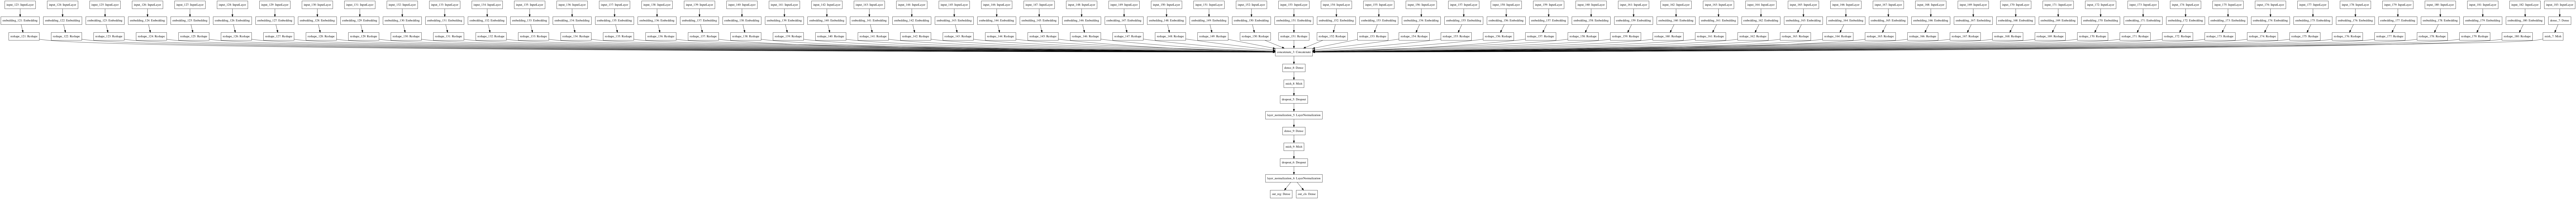

In [23]:
from keras.utils import plot_model
plot_model(model, to_file=datapath + '/figs/model.png')

# CV

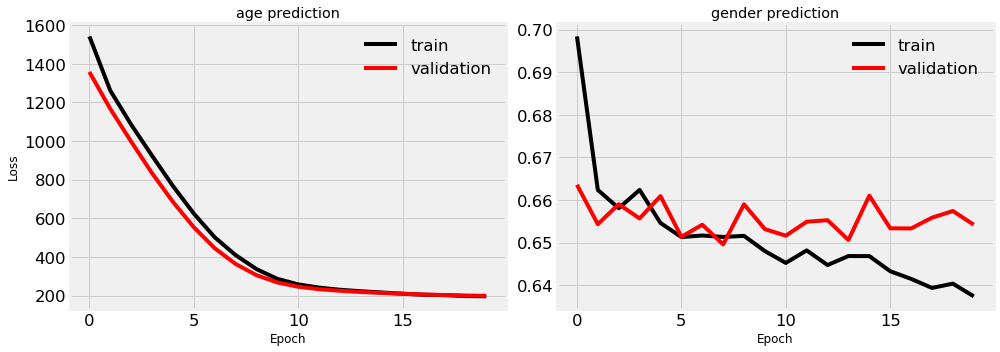

In [23]:
# plot loss
def plot_loss(i):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax = ax.flatten()
    tr_reg_loss = np.array(histories[0].history["out_reg_loss"])
    tr_cls_loss = np.array(histories[0].history["out_cls_loss"])
    val_reg_loss = np.array(histories[0].history["val_out_reg_loss"])
    val_cls_loss = np.array(histories[0].history["val_out_cls_loss"])
    n_len = len(histories)
    for h in histories[1:]:
        tr_reg_loss += np.array(h.history["out_reg_loss"])  
        tr_cls_loss += np.array(h.history["out_cls_loss"])
        val_reg_loss += np.array(h.history["val_out_reg_loss"])
        val_cls_loss += np.array(h.history["val_out_cls_loss"])
    # regression task
    ax[0].plot(tr_reg_loss / n_len, color="k", label="train")
    ax[0].plot(val_reg_loss / n_len, color="r", label="validation")
    ax[0].set_title("age prediction")
    
    # regression task
    ax[1].plot(tr_cls_loss / n_len, color="k", label="train")
    ax[1].plot(val_cls_loss / n_len, color="r", label="validation")
    ax[1].set_title("gender prediction")
    
    # format
    ax[0].set_ylabel('Loss')
    for i in np.arange(2):
        ax[i].set_xlabel('Epoch')
        ax[i].legend(loc='upper left ', frameon=False)
    plt.tight_layout()
plot_loss(n_splits-1)
plt.savefig(datapath +"/figs/loss_plot.png", bbox_inches='tight')

In [24]:
# final cv
print(f"Final cv score for age = {np.sqrt(mean_squared_error(train[target[0]].values, oof_pred[:, 0]))}")
print(f"Final cv score for gender = {roc_auc_score(train[target[1]].values, oof_pred[:, 1])}")

Final cv score for age = 13.974072902315228
Final cv score for gender = 0.6431823040900516


# Permutation importance

In [25]:
def calc_metric(model, X, y):
    loss_reg = np.sqrt(mean_squared_error(y[0], model.predict(X)[0].ravel()))
    loss_cls = log_loss(y[1], model.predict(X)[1].ravel())
    return loss_reg + loss_cls * 1000

def permutation_importance(model, X, y, cat_features, dense_features):
    baseline = calc_metric(model, X, y)
    imp = []
    # categorical features
    for idx, f in tqdm(enumerate(cat_features)):
        save = X[idx].copy()
        X[idx] = np.random.permutation(X[idx])
        m = calc_metric(model, X, y)
        X[idx] = save
        imp.append(baseline - m)
        print(f"importance of {f} = {baseline - m}")
        
    # dense features
    n_cat = len(cat_features)
    for idx, f in tqdm(enumerate(dense_features)):
        save = X[n_cat][f].copy()
        X[n_cat][f] = np.random.permutation(X[n_cat][f])
        m = calc_metric(model, X, y)
        X[n_cat][f] = save
        imp.append(baseline - m)
        print(f"importance of {f} = {baseline - m}")
    return np.array(imp)
    
# perform permutation importance
features = cat_features + dense_features
imp = permutation_importance(model, x_train, [y_train_age.values, y_train_gen.values], 
                            cat_features, dense_features)

importance of 2_user_profile_master_commerce_premium_user_flag = -1.2197233893245993
importance of 2_user_profile_master_commerce_wallet_registered_flag = -3.28353812035607
importance of 2_user_profile_master_commerce_valid_card_count = -1.6652197228825116
importance of 2_user_profile_master_commerce_auction_store_flag = 0.0
importance of 8_app_user_monthly_stats_toppage_flag = -0.3654463048845855
importance of 8_app_user_monthly_stats_weather_flag = -0.6526311997063203
importance of 8_app_user_monthly_stats_transit_flag = -0.520833641302147
importance of 8_app_user_monthly_stats_shopping_flag = -1.9789585796532947
importance of 8_app_user_monthly_stats_gyao_flag = -1.3913320044276816
importance of 8_app_user_monthly_stats_auctions_flag = -4.8371708052626445
importance of 8_app_user_monthly_stats_mail_flag = -0.1714144407343383
importance of 8_app_user_monthly_stats_yjtrend_flag = -3.673515147947228
importance of 8_app_user_monthly_stats_apppkgcal_flag = -3.9704174897958637
importance 

importance of 1_y_id_master_registration_date = -1.656156908788489
importance of 1_y_id_master_first_update = -1.106053115462828
importance of 1_y_id_master_last_update = -0.3542604087781456
importance of 1_y_id_master_registration_month = -3.061680176264531
importance of 1_y_id_master_registration_week = -1.9041183166986002
importance of 2_user_profile_master_commerce_registration_month = 0.09882601108699873
importance of 2_user_profile_master_commerce_shopping_order_count = -1.1384561202650048
importance of 2_user_profile_master_commerce_auction_won_count = -0.08129355363269042
importance of 2_user_profile_master_commerce_auction_bid_aid_count = -0.1724851948736159
importance of 2_user_profile_master_commerce_auction_submit_count = -7.687154027280485e-05
importance of 2_user_profile_master_commerce_auction_sold_count = -0.000949409128111256
importance of 2_user_profile_master_commerce_earned_point_count = -0.07039256293330709
importance of 2_user_profile_master_commerce_monthly_fixed

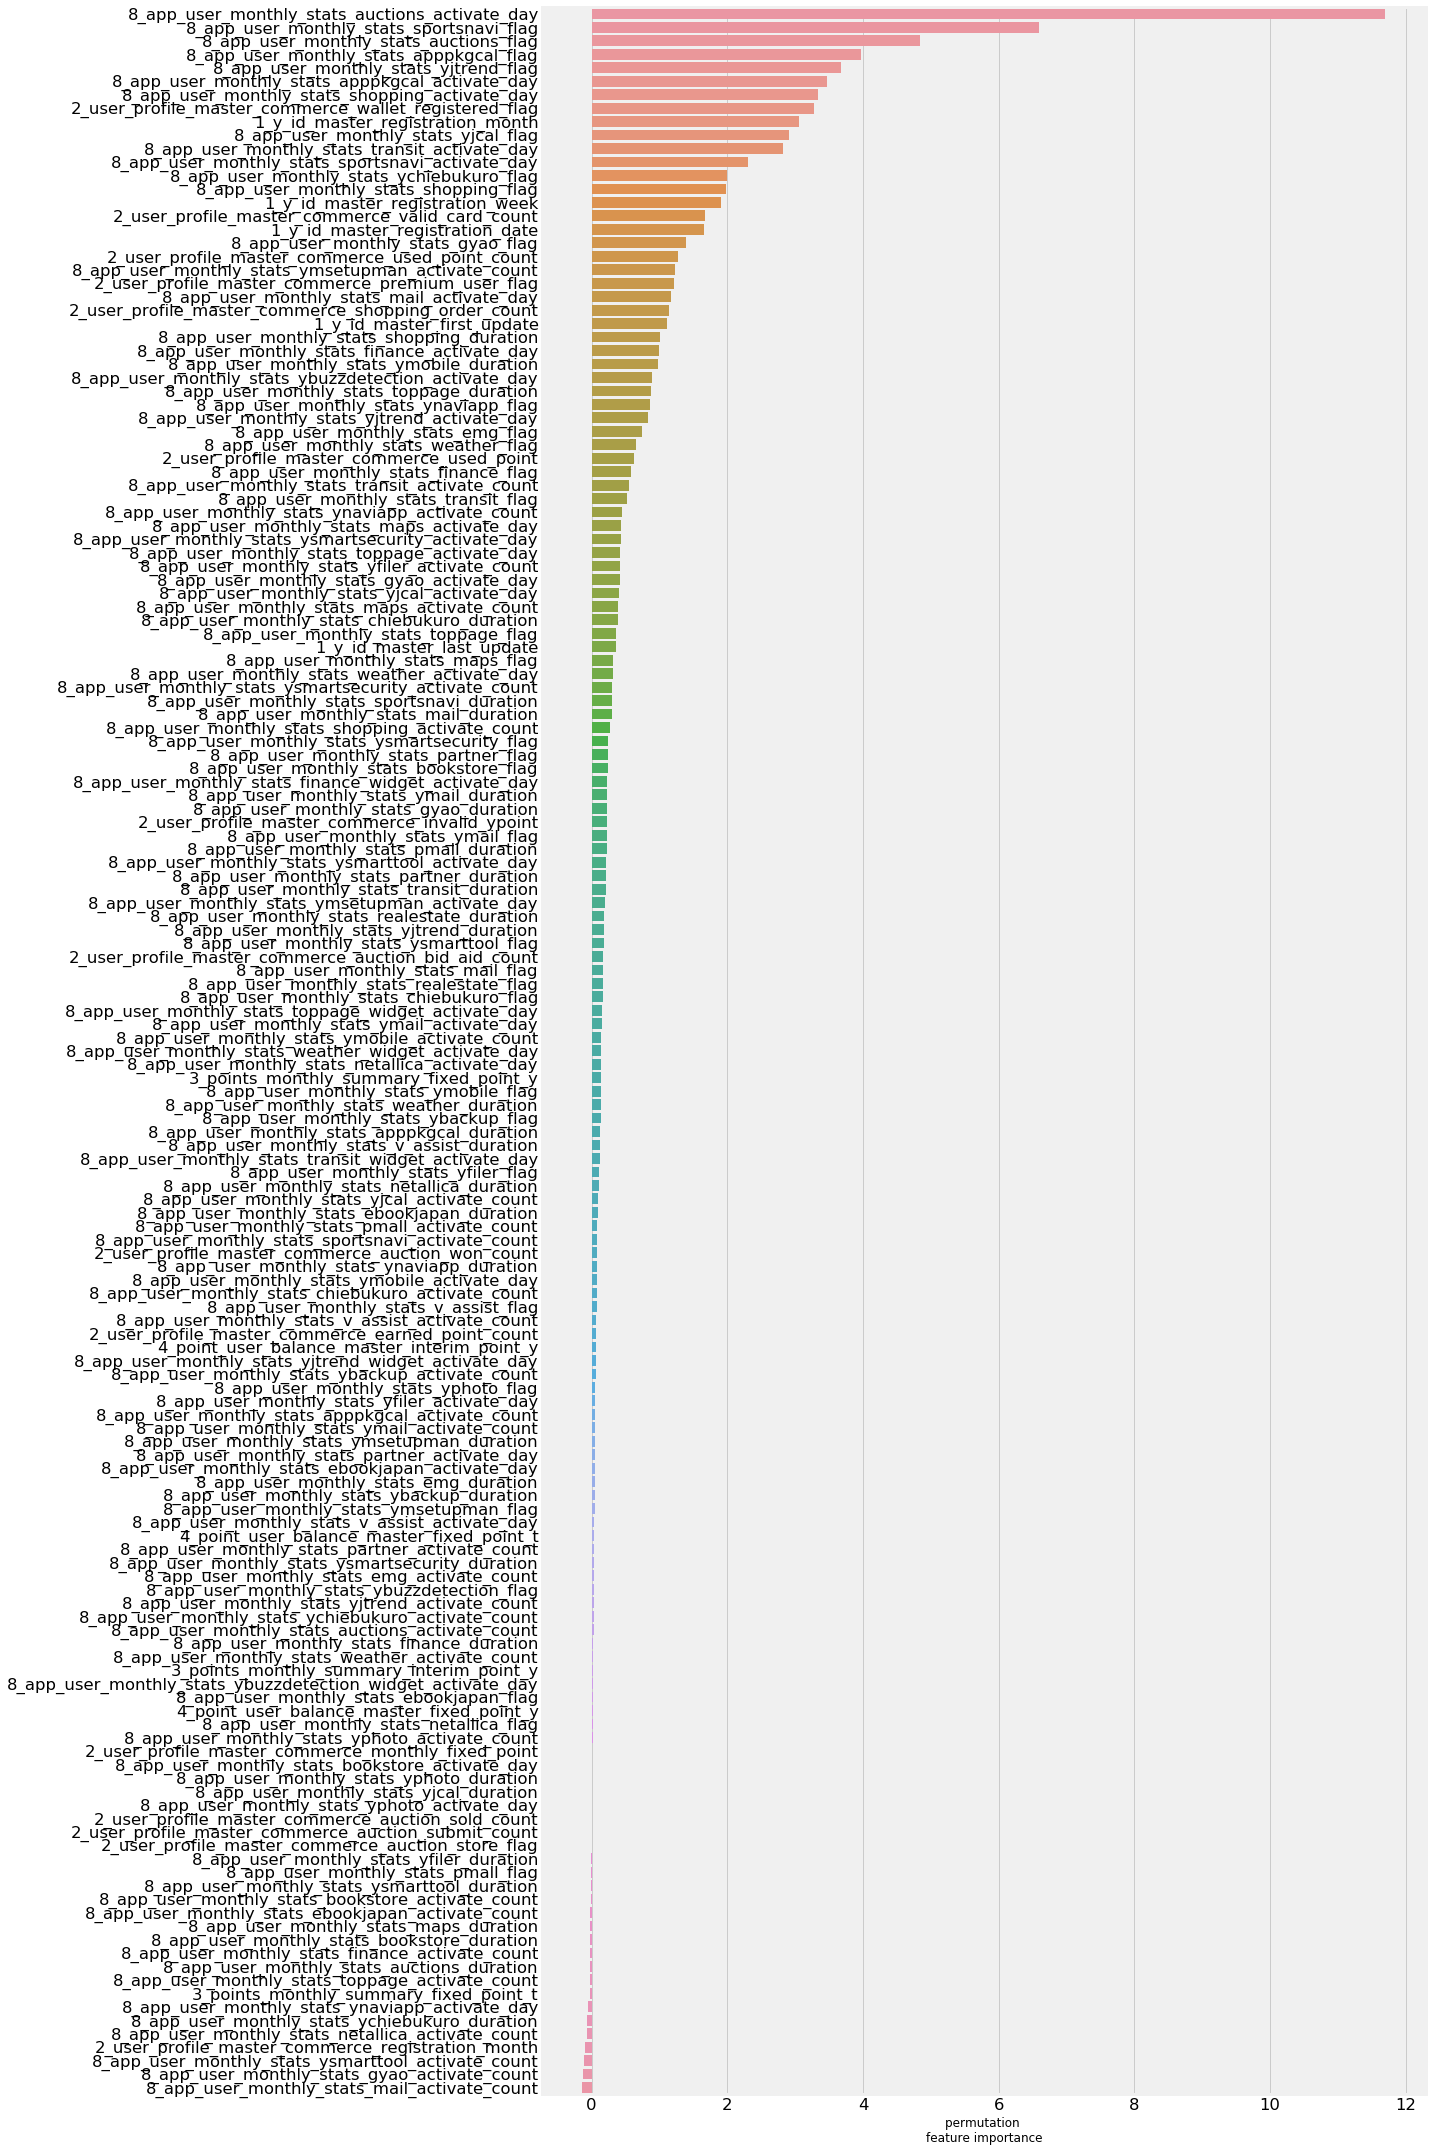

In [26]:
# plot 
ranking = np.argsort(imp)
f, ax = plt.subplots(figsize=(20, 30))
sns.barplot(x=-imp[ranking], y=np.array(features)[ranking], orient='h')
ax.set_xlabel("permutation \nfeature importance")
plt.tight_layout()
plt.show()

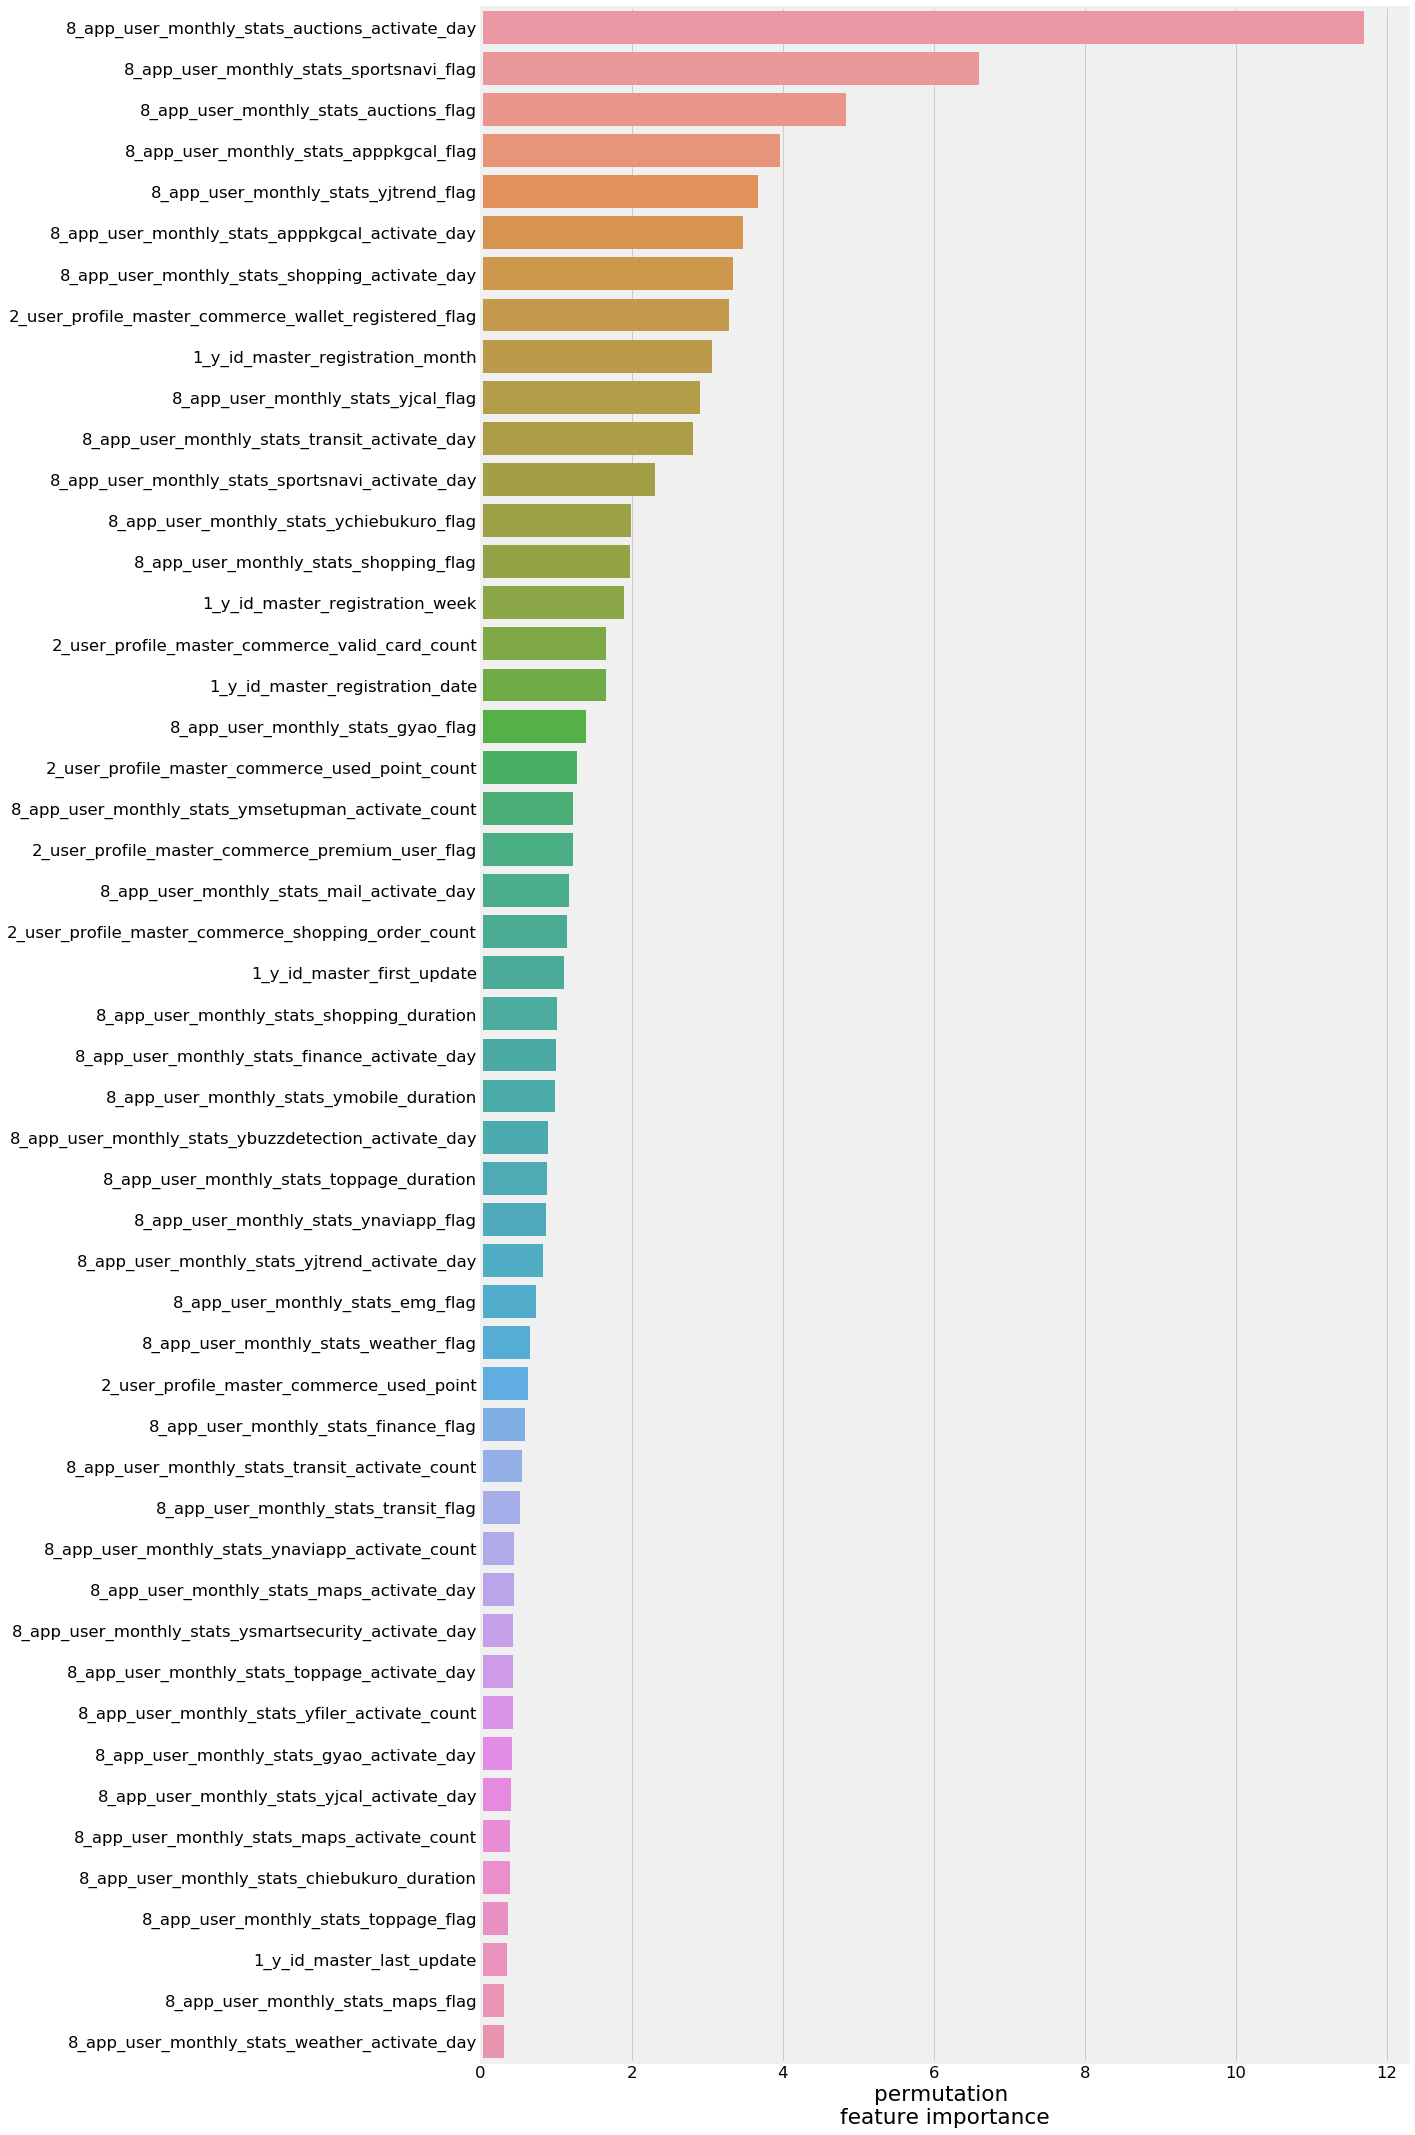

In [36]:
# plot 
top_n = 50
ranking = np.argsort(imp)
f, ax = plt.subplots(figsize=(20, 30))
sns.barplot(x=-imp[ranking][:top_n], y=np.array(features)[ranking][:top_n], orient='h')
ax.set_xlabel("permutation \nfeature importance")
plt.tight_layout()
plt.rcParams.update({'font.size': 18})

plt.savefig(datapath +"/figs/feature_importance.png", bbox_inches='tight')